In [1]:
import numpy as np
import datetime
import tensorflow as tf
from library.models import Generator,Discriminator
from library.losses import discriminator_loss,generator_loss
from library.lr_schedules import ExponentialDecay
from library.dataset import load_mnist

# GAN

In [2]:
class Generative_Adverserial_Nets:
    def __init__(self,dataset,noise_dim=100,batch_size=100,K=1):
        self.dataset=dataset
        self.feature_dim=dataset.shape[1]
        self.noise_dim=noise_dim
        self.batch_size=batch_size
        self.K=K
        
        
        self.G=Generator(self.noise_dim,self.feature_dim)
        self.D=Discriminator(self.feature_dim)

        self.G_optim=tf.keras.optimizers.SGD(learning_rate=ExponentialDecay(0.1,1.000004,0.000001),momentum=.7)
        self.D_optim=tf.keras.optimizers.SGD(learning_rate=ExponentialDecay(0.1,1.000004,0.000001),momentum=.7)  
        
        
        self.current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = 'logs/VGAN/' + self.current_time
        self.summary_writer = tf.summary.create_file_writer(self.log_dir)
        
        self.i=0 #trained for i steps
        
    
    def sample_noise(self,batch_size):
        return np.random.uniform(-np.sqrt(3),+np.sqrt(3),size=(batch_size,self.noise_dim))
        
    def sample_data(self,batch_size):
        ind=np.random.randint(0,self.dataset.shape[0],batch_size)
        return self.dataset[ind]
    
    
    def train_for_1_step(self,batch_size,K):
        D_LOSS=0
        for _ in range(K):
            with tf.GradientTape() as t1:
                z=self.sample_noise(batch_size)
                x=self.sample_data(batch_size)
                d_loss=discriminator_loss(self.D,self.G,x,z)
                D_LOSS+=d_loss.numpy()
            d_grads=t1.gradient(d_loss,self.D.trainable_variables)
            self.D_optim.apply_gradients(zip(d_grads,self.D.trainable_variables))
        D_LOSS/=K

        G_LOSS=0
        with tf.GradientTape() as t2:
            z=self.sample_noise(batch_size)
            g_loss=generator_loss(self.D,self.G,z)
            G_LOSS+=g_loss.numpy()
        g_grads=t2.gradient(g_loss,self.G.trainable_variables)
        self.G_optim.apply_gradients(zip(g_grads,self.G.trainable_variables))

        return D_LOSS,G_LOSS
    
    
    def train(self,steps=50000,log_step=10):
        while self.i<steps:
            D_LOSS,G_LOSS=self.train_for_1_step(self.batch_size,self.K)
            
            if self.i%log_step==0:
                with self.summary_writer.as_default():
                    tf.summary.scalar('loss/Generator', G_LOSS, step=self.i)
                    tf.summary.scalar('loss/Discriminator', D_LOSS, step=self.i)
                
            self.i+=1

In [3]:
gan=Generative_Adverserial_Nets(load_mnist(), noise_dim=100, batch_size=100, K=1)

In [4]:
gan.train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: 

In [5]:
img=gan.G.predict(gan.sample_noise(1))

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

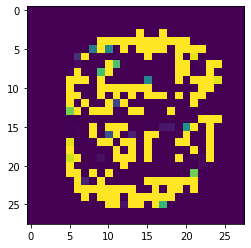

In [7]:
plt.imshow(img[0].reshape(28,28))